Exercise 2

In [1]:
#%matplotlib inline
#%load_ext tensorboard

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, TensorDataset
import copy

# Making the code device-agnostic
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

#from __future__ import print_function
import time

import numpy as np
import pandas as pd

#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

In [3]:
print(f'Is available: {torch.cuda.is_available()}')
print(f'Device count: {torch.cuda.device_count()}')
print(f'Current device: {torch.cuda.current_device()}')
print(f'Device 0: {torch.cuda.device(0)}')
print(f'Get device name 0: {torch.cuda.get_device_name(0)}')

Is available: True
Device count: 1
Current device: 0
Device 0: <torch.cuda.device object at 0x7950d9b65590>
Get device name 0: Tesla P100-PCIE-16GB


In [4]:
# Train augmentations
train_test_transform = transforms.Compose([
    transforms.ToTensor(),
])

mnist_train = datasets.MNIST(root='D:/Dev/auto_download_data/D7047E/MNIST',
                                             train=True,
                                             download=True,
                                             transform=train_test_transform)
mnist_test = datasets.MNIST(root='D:/Dev/auto_download_data/D7047E/MNIST',
                                            train=False,
                                            download=True,
                                            transform=train_test_transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to D:/Dev/auto_download_data/D7047E/MNIST/MNIST/raw



In [5]:
# Hyperparameters
BATCH_SIZE = 100
SHUFFLE = True
LEARNING_RATE = 1e-6
epochs = 1

# Train 80 %, Validation 20 % of test set
train_set, val_set = torch.utils.data.random_split(mnist_train, [0.8, 0.2], generator=torch.Generator())

train_loader_mnist = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_loader_mnist = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader_mnist = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=SHUFFLE)


In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    tb = SummaryWriter()

    for epoch in range(num_epochs):

        train_loss_sum = 0
        train_correct = 0
        train_total = 0

        for batch_nr, (inputs, labels) in enumerate(train_loader):

            # Convert to one hot tensors
            labels = F.one_hot(labels, 10).float()

            # Forward pass
            predictions = model(inputs.to(device))

            # Calculate loss
            loss = criterion(predictions, labels.to(device))
            train_loss = loss.item() * inputs.size(0)
            train_loss_sum += loss.item() * inputs.size(0)

            # Calculate accuracy
            for i, _ in enumerate(predictions):
                if torch.argmax(labels[i]) == torch.argmax(predictions[i]):
                    train_correct += 1
                train_total += 1

            # Backpropagation
            loss.backward()

            # Update parameters
            optimizer.step()

            # Clear
            optimizer.zero_grad()

            # Print the epoch and loss
            print('\r', f'Epoch {epoch+1} - Train loss: {train_loss_sum / train_total} - Accuracy: {train_correct / train_total:.2f}', end='')

            # Add to tensorboard
            tb.add_scalar("Loss", train_loss, batch_nr)
            tb.add_scalar("Accuracy", train_correct / train_total, batch_nr)

            #tb.add_histogram("conv1.bias", model.conv1.bias, batch_nr)
            #tb.add_histogram("conv1.weight", model.conv1.weight, batch_nr)
            #tb.add_histogram("conv2.bias", model.conv2.bias, batch_nr)
            #tb.add_histogram("conv2.weight", model.conv2.weight, batch_nr)

        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        train_losses.append(train_loss_sum / train_total)
        train_accuracies.append(train_correct / train_total)

        # Print the epoch and loss
        #print(f'Epoch {epoch+1} - Train loss: {train_loss_sum / train_total} - Accuracy: {train_correct / train_total:.2f}')
        print('')

        val_loss_sum = 0
        val_correct = 0
        val_total = 0

        for batch_nr, (inputs, labels) in enumerate(val_loader):

            # Convert to one hot tensors
            labels = F.one_hot(labels, 10).float()

            # Forward pass
            predictions = model(inputs.to(device))

            # Calculate loss
            loss = criterion(predictions, labels.to(device))
            val_loss_sum += loss.item() * inputs.size(0)

            # Calculate accuracy
            for i, _ in enumerate(predictions):
                if torch.argmax(labels[i]) == torch.argmax(predictions[i]):
                    val_correct += 1
                val_total += 1

        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        val_losses.append(val_loss_sum / val_total)
        val_accuracies.append(val_correct / val_total)

        # Print the epoch and loss
        print(f'Epoch {epoch+1} - Validation loss: {val_loss_sum / val_total} - Accuracy: {val_correct / val_total:.2f}')
        print('')

    tb.close()

    return model


def test_model(model, criterion, test_loader):

    test_losses = []
    y_pred = []
    y_true = []

    test_loss_sum = 0
    test_correct = 0
    test_total = 0

    for batch_nr, (inputs, labels) in enumerate(test_loader):

        # Convert to one hot tensors
        labels = F.one_hot(labels, 10).float()

        for label in labels:
            y_true.append(torch.argmax(label)) # Save Truth

        # Forward pass
        predictions = model(inputs.to(device))

        for prediction in predictions:
            y_pred.append(torch.argmax(prediction)) # Save Prediction

        # Calculate loss
        loss = criterion(predictions, labels.to(device))
        test_loss_sum += loss.item() * inputs.size(0)

        # Calculate accuracy
        for i, _ in enumerate(predictions):
            if torch.argmax(labels[i]) == torch.argmax(predictions[i]):
                test_correct += 1
            test_total += 1

    # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
    test_losses.append(test_loss_sum / test_total)

    # Print the epoch and loss
    print(f'Test loss: {test_loss_sum / test_total} - Accuracy: {test_correct / test_total:.2f}')

    return

def get_features(model, data_loader):
    
    features_list = []
    labels_list = []
    
    for batch_nr, (inputs, labels) in enumerate(data_loader):
        # Extract features
        features_list.append(model.feat(inputs.to(device)))
        labels_list.append(labels)
    
    features_tensor = torch.cat(features_list)    
    labels_tensor = torch.cat(labels_list)

    return features_tensor, labels_tensor


In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def feat(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        return x
    

## Model with 1e-6 and 1 epoch

In [8]:

model_mnist = Net()
model_mnist = model_mnist.to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
#optimizer = torch.optim.Adam(model_mnist.parameters(), LEARNING_RATE)
optimizer_mnist = torch.optim.SGD(model_mnist.parameters(), LEARNING_RATE)

# Train the model
trained_model_mnist_1e6 = train_model(model_mnist, criterion, optimizer_mnist, train_loader_mnist, val_loader_mnist, epochs)

# Test the model
test_model(trained_model_mnist_1e6, criterion, test_loader_mnist)

 Epoch 1 - Train loss: 2.300310682753722 - Accuracy: 0.100
Epoch 1 - Validation loss: 2.299682495991389 - Accuracy: 0.10

Test loss: 2.300071394443512 - Accuracy: 0.10


In [9]:
X, y = get_features(trained_model_mnist_1e6, train_loader_mnist)

print(X.shape)
print(y)

feat_cols = [ 'feature'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X.cpu().detach().numpy(), columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))

print(df)


torch.Size([48000, 1024])
tensor([5, 5, 2,  ..., 2, 0, 1])
Size of the dataframe: (48000, 1026)
       feature0  feature1  feature2  feature3  feature4  feature5  feature6  \
0      0.142918  0.042034  0.006081  0.089135  0.131516  0.049654  0.188111   
1      0.111696  0.000000  0.000000  0.000000  0.153094  0.083532  0.163709   
2      0.000000  0.070032  0.083576  0.000000  0.227273  0.303409  0.000000   
3      0.000000  0.102030  0.070481  0.009257  0.029005  0.200076  0.000000   
4      0.164346  0.000000  0.000000  0.000000  0.081025  0.116927  0.194232   
...         ...       ...       ...       ...       ...       ...       ...   
47995  0.101805  0.000000  0.000000  0.000000  0.125916  0.149973  0.139011   
47996  0.082466  0.023829  0.118822  0.062496  0.129851  0.103601  0.262261   
47997  0.042070  0.044480  0.082541  0.000000  0.129073  0.161734  0.079786   
47998  0.081895  0.053051  0.050578  0.095483  0.088401  0.000000  0.136787   
47999  0.066808  0.040806  0.000000

In [10]:
# For reproducability of the results
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])

In [11]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.15201119 0.08657667 0.07766841]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

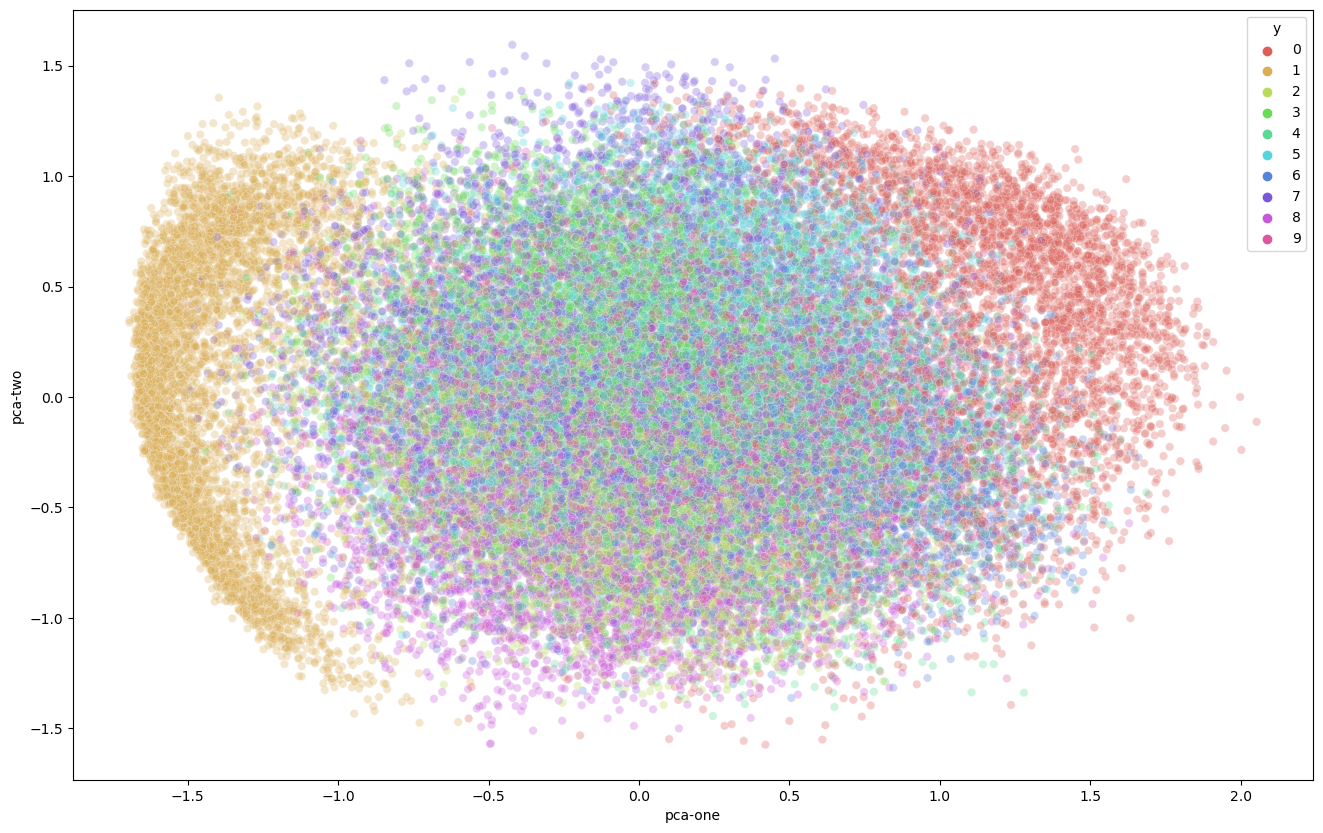

In [12]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

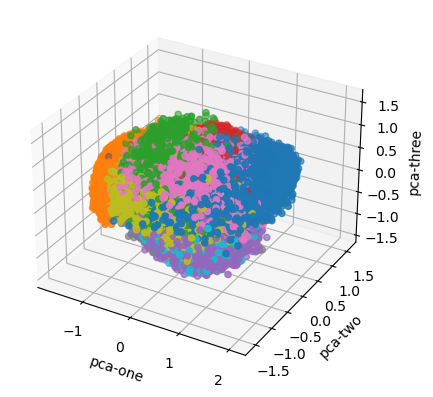

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [14]:
N = 48000

df_subset = df.loc[rndperm[:N],:].copy()

data_subset = df_subset[feat_cols].values

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.15201004 0.08657602 0.07766785]


In [15]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 48000 samples in 0.054s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 48000 samples in 133.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48000
[t-SNE] Computed conditional probabilities for sample 2000 / 48000
[t-SNE] Computed conditional probabilities for sample 3000 / 48000
[t-SNE] Computed conditional probabilities for sample 4000 / 48000
[t-SNE] Computed conditional probabilities for sample 5000 / 48000
[t-SNE] Computed conditional probabilities for sample 6000 / 48000
[t-SNE] Computed conditional probabilities for sample 7000 / 48000
[t-SNE] Computed conditional probabilities for sample 8000 / 48000
[t-SNE] Computed conditional probabilities for sample 9000 / 48000
[t-SNE] Computed conditional probabilities for sample 10000 / 48000
[t-SNE] Computed conditional probabilities for sample 11000 / 48000
[t-SNE] Computed conditional probabilities for sample 12000 / 48000
[t-SNE] Computed conditional probabilities for sample 13000 / 48000
[t-SNE] Computed conditional probabilities for sample 14000 / 480

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

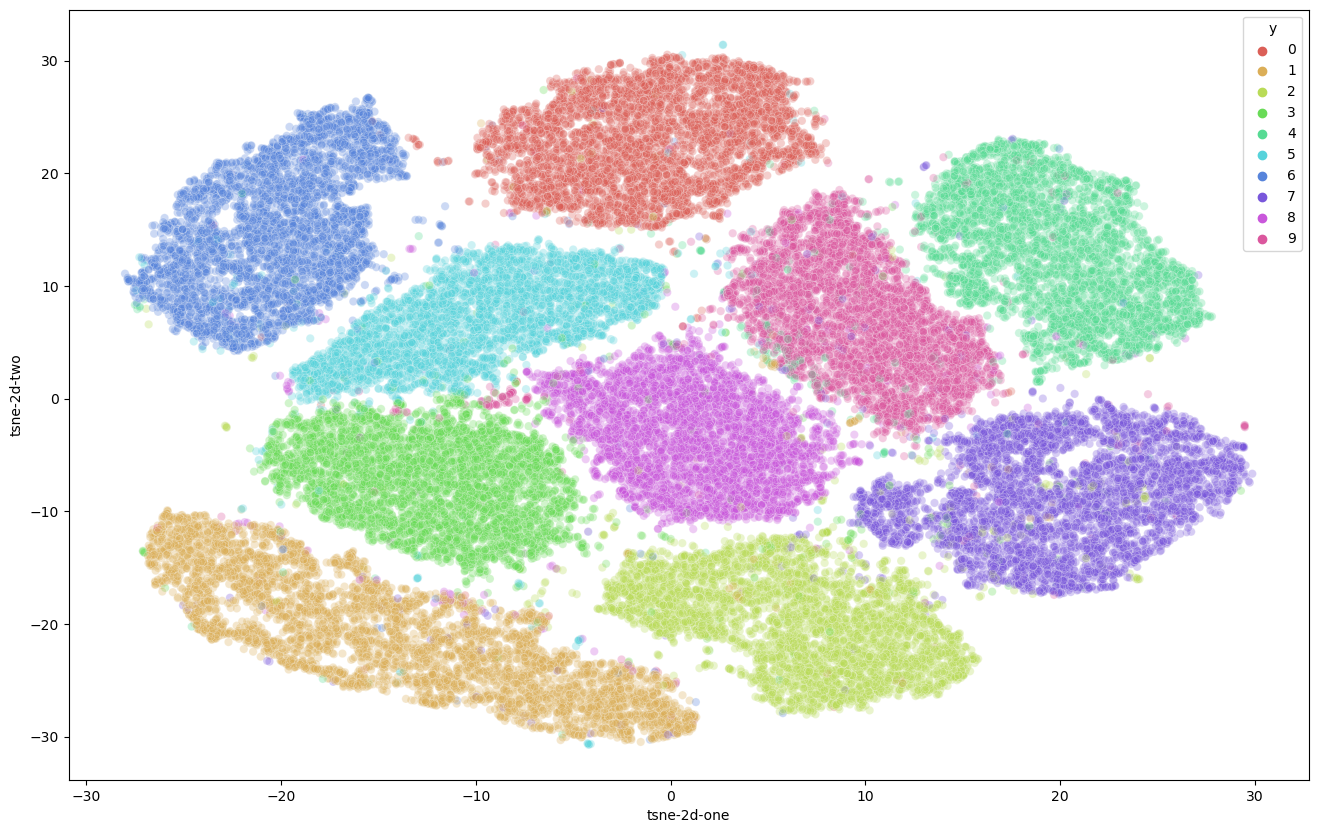

In [16]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

## Model with 1e-3 and 20 epochs

In [17]:
# Hyperparameters
BATCH_SIZE = 100
SHUFFLE = True
LEARNING_RATE = 1e-3
epochs = 20

model_mnist = Net()
model_mnist = model_mnist.to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
#optimizer = torch.optim.Adam(model_mnist.parameters(), LEARNING_RATE)
optimizer_mnist = torch.optim.SGD(model_mnist.parameters(), LEARNING_RATE)

# Train the model
trained_model_mnist_1e3 = train_model(model_mnist, criterion, optimizer_mnist, train_loader_mnist, val_loader_mnist, epochs)

# Test the model
test_model(trained_model_mnist_1e3, criterion, test_loader_mnist)

 Epoch 1 - Train loss: 2.296753084162871 - Accuracy: 0.088
Epoch 1 - Validation loss: 2.290227649609248 - Accuracy: 0.11

 Epoch 2 - Train loss: 2.282479846974214 - Accuracy: 0.155
Epoch 2 - Validation loss: 2.274891048669815 - Accuracy: 0.20

 Epoch 3 - Train loss: 2.2637617910901704 - Accuracy: 0.28
Epoch 3 - Validation loss: 2.2518361171086627 - Accuracy: 0.36

 Epoch 4 - Train loss: 2.2343262135982513 - Accuracy: 0.48
Epoch 4 - Validation loss: 2.2143214066823322 - Accuracy: 0.57

 Epoch 5 - Train loss: 2.1834899758299193 - Accuracy: 0.63
Epoch 5 - Validation loss: 2.1460565785566965 - Accuracy: 0.69

 Epoch 6 - Train loss: 2.0832691848278047 - Accuracy: 0.71
Epoch 6 - Validation loss: 2.0005555589993795 - Accuracy: 0.73

 Epoch 7 - Train loss: 1.8550506676236789 - Accuracy: 0.74
Epoch 7 - Validation loss: 1.663767111301422 - Accuracy: 0.75

 Epoch 8 - Train loss: 1.395017521455884 - Accuracy: 0.777
Epoch 8 - Validation loss: 1.11811805665493 - Accuracy: 0.79

 Epoch 9 - Train loss

In [18]:
X, y = get_features(trained_model_mnist_1e3, train_loader_mnist)

print(X.shape)
print(y)


feat_cols = [ 'feature'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X.cpu().detach().numpy(), columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))

torch.Size([48000, 1024])
tensor([4, 2, 0,  ..., 1, 1, 2])
Size of the dataframe: (48000, 1026)


In [19]:
# For reproducability of the results
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])

In [20]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26884767 0.12972146 0.12071453]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

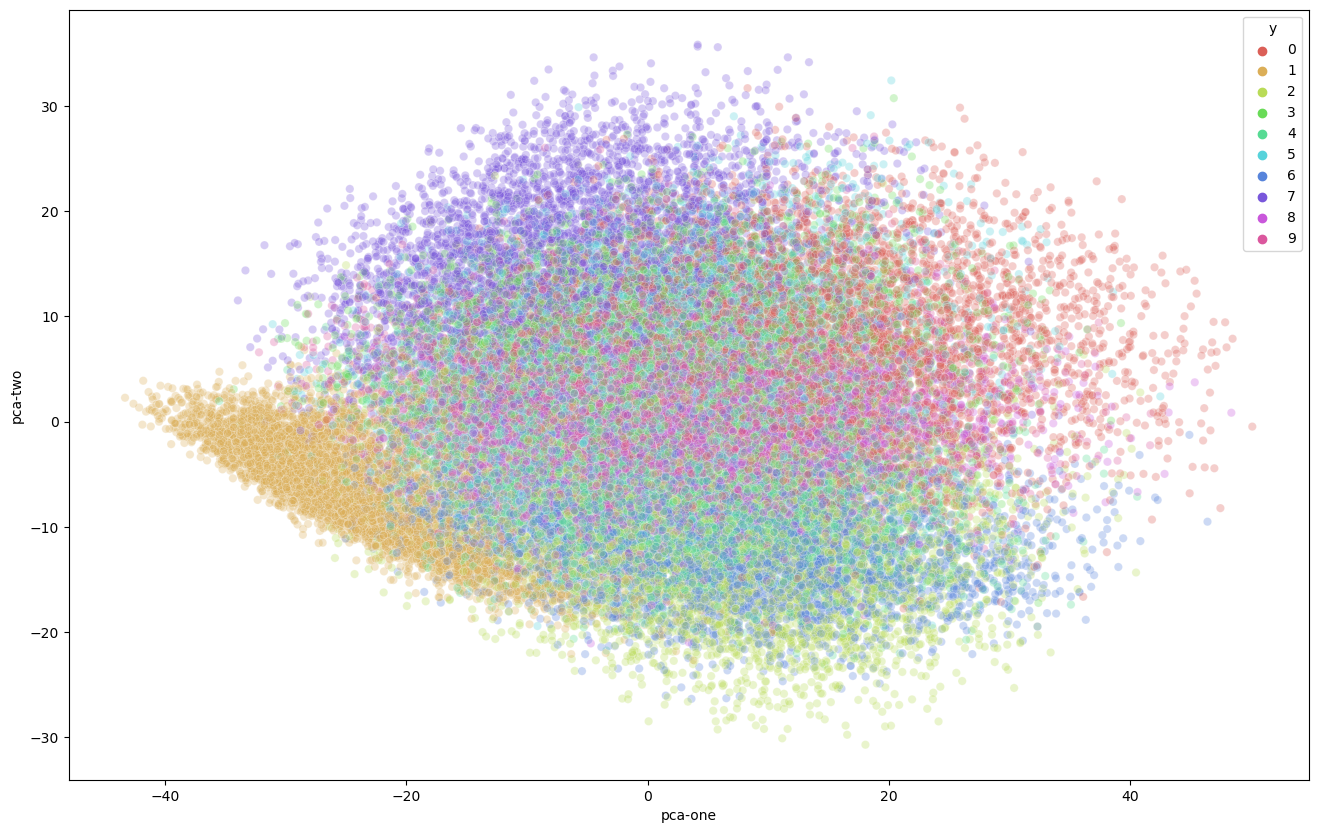

In [21]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

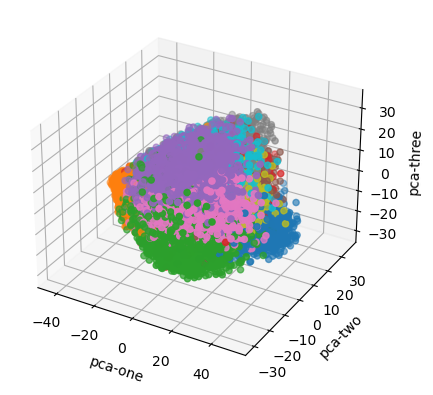

In [22]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [23]:
N = 48000

df_subset = df.loc[rndperm[:N],:].copy()

data_subset = df_subset[feat_cols].values

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.26884642 0.129721   0.12071411]


In [24]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 48000 samples in 0.035s...


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 48000 samples in 129.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48000
[t-SNE] Computed conditional probabilities for sample 2000 / 48000
[t-SNE] Computed conditional probabilities for sample 3000 / 48000
[t-SNE] Computed conditional probabilities for sample 4000 / 48000
[t-SNE] Computed conditional probabilities for sample 5000 / 48000
[t-SNE] Computed conditional probabilities for sample 6000 / 48000
[t-SNE] Computed conditional probabilities for sample 7000 / 48000
[t-SNE] Computed conditional probabilities for sample 8000 / 48000
[t-SNE] Computed conditional probabilities for sample 9000 / 48000
[t-SNE] Computed conditional probabilities for sample 10000 / 48000
[t-SNE] Computed conditional probabilities for sample 11000 / 48000
[t-SNE] Computed conditional probabilities for sample 12000 / 48000
[t-SNE] Computed conditional probabilities for sample 13000 / 48000
[t-SNE] Computed conditional probabilities for sample 14000 / 480

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

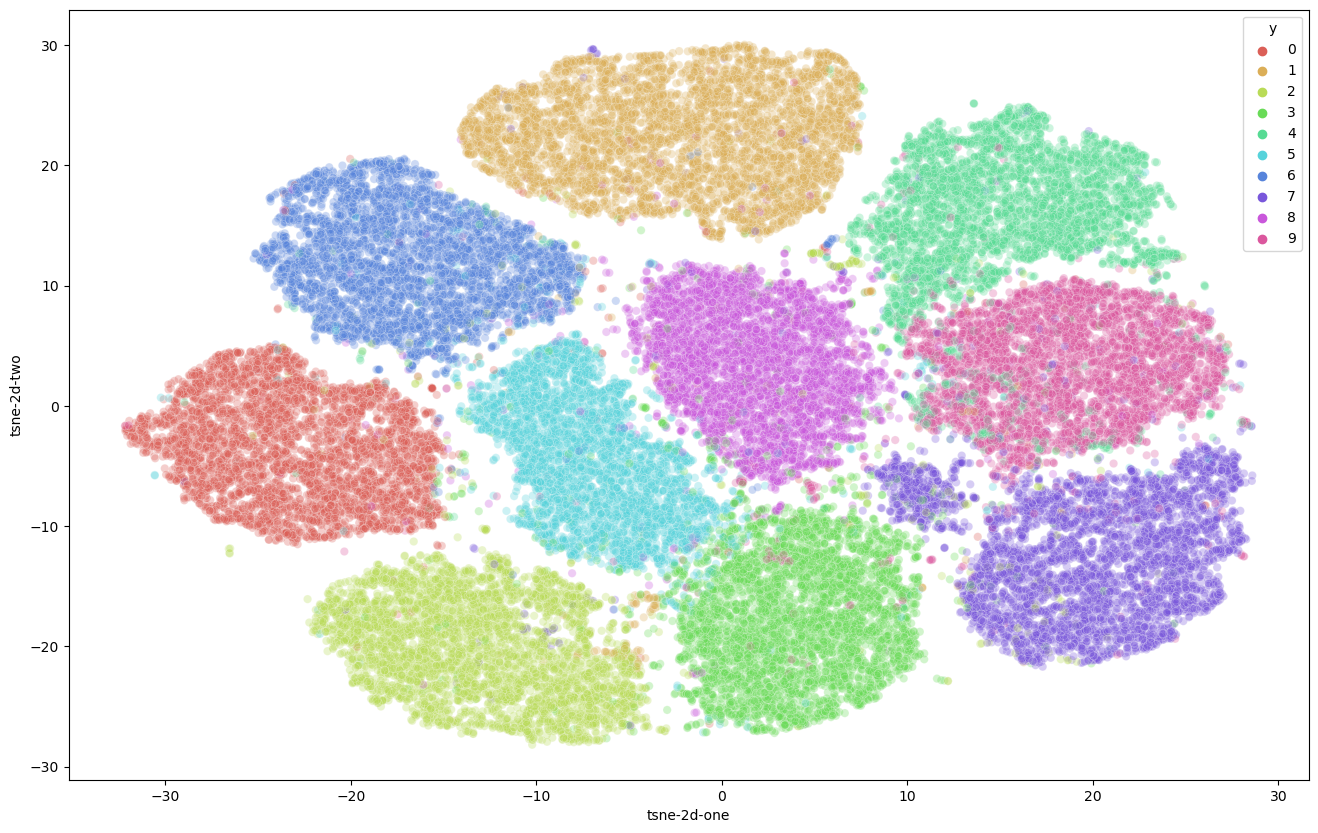

In [25]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)